In [1]:
from regseg import RegSeg, train_loop
import pytorch_lightning as pl
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
import torch

In [2]:
# final
params = {"loss_name":"BCEWeighted", "optimizer_name":"Adam",
          "weight": [ 0.0423,  1.2298,  4.5671,  1.4371,  0.4330,  2.7586,  7.4159,  0.0678, 0.0874, 13.7053,  4.0711],
          "lr": 1e-3, "weight_decay":0, "automatic_optimization":True, "scheduler_type":"Plateau",
         "scheduler_patience":3, "num_classes":11}

# callbacks utils
logger_name = f"regseg_final_16"
logger_save_path = "../data/logs/regseg/"
callback_name = f"regseg_final_16"
callback_save_path = "../data/models/regseg/"

In [3]:
model = RegSeg(
        loss_name=params["loss_name"],
        optimizer_name=params["optimizer_name"],
        weight=params["weight"],
        lr=params["lr"],
        weight_decay=params["weight_decay"],
        automatic_optimization=params["automatic_optimization"],
        scheduler_type=params["scheduler_type"],
        scheduler_patience=params["scheduler_patience"] 
    )
model = model.load_from_checkpoint(f"{callback_save_path}/{callback_name}.ckpt")
_ = model.eval()


In [4]:
%%time
from data import get_data_paths, celeb2mask, CustomDataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import time
import torch
from tqdm.notebook import tqdm

from warnings import filterwarnings
filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2

# get data paths
data_paths = get_data_paths(celeb_img_path="../data/dataset_celebs/imgs_256/*.jpg",
                            celeb_mask_path="../data/dataset_celebs/masks_256/")
# data_paths = [i for i in data_paths if i[0] == "community_dataset"]
# data_paths = [i for i in data_paths if i[0] != "community_dataset"]
# np.random.shuffle(data_paths)
# data_paths = data_paths[:100]

# split data
train_paths, test_paths = train_test_split(data_paths, test_size=0.2, random_state=42)
test_paths, val_paths = train_test_split(test_paths, test_size=0.5, random_state=42)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

# Datasets
train_dataset = CustomDataset(train_paths, num_classes="all")
val_dataset = CustomDataset(val_paths, num_classes="all")
test_dataset = CustomDataset(test_paths, num_classes="all")

# Dataloaders
torch.manual_seed(42)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

del train_dataset, val_dataset, test_dataset

Train: 33439, Val: 4180, Test: 4180
CPU times: user 3.29 s, sys: 187 ms, total: 3.48 s
Wall time: 3.59 s


In [65]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, accuracy_score

In [66]:
score_check = []
score_check2 = []

model = model.to("cuda")
cfm = np.zeros((11, 11))

for x, mask in tqdm(test_dataloader):
    # get preds
    logits_mask = model(x.to("cuda")).to("cpu")
    # get pred_mask
    prob_mask = logits_mask.sigmoid()
    pred_mask = prob_mask > 0.5
    # get new data
    new_preds = []
    new_mask = []
    for i in range(11):
        temp_pred = pred_mask[0, i].view(-1, 1).long().numpy()
        temp_mask = mask[0, i].view(-1, 1).long().numpy()

        temp_pred[temp_pred] = i
        temp_mask[temp_mask] = i

        new_preds.extend(temp_pred.reshape(1, -1)[0])
        new_mask.extend(temp_mask.reshape(1, -1)[0])
        
        
        if i == 1:
            temp_score = f1_score(temp_pred.reshape(1, -1)[0], temp_mask.reshape(1, -1)[0], average="micro")
            temp_score2 = accuracy_score(temp_pred.reshape(1, -1)[0], temp_mask.reshape(1, -1)[0])
            
            score_check.append(temp_score)
            score_check2.append(temp_score2)
        
    cfm_batch = confusion_matrix(new_mask, new_preds)
    cfm += cfm_batch
        
#     break

  0%|          | 0/4180 [00:00<?, ?it/s]

In [67]:
np.mean(score_check), np.mean(score_check2)

(0.9982059657183746, 0.9982059657183746)

<Figure size 1152x1008 with 0 Axes>

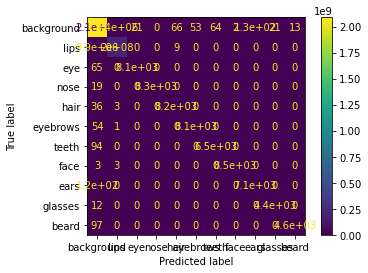

In [68]:
# cfm_final = cfm / cfm.sum()
CLASSES = {"background": [0, 0, 0], "lips": [255, 0, 0], "eye": [0, 255, 0], "nose": [0, 0, 255],
           "hair": [255, 255, 0], "eyebrows": [255, 0, 255], "teeth": [255, 255, 255], "face": [128, 128, 128],
           "ears": [0, 255, 255], "glasses": [0, 128, 128], "beard": [255, 192, 192]}

plt.figure(figsize=(16, 14))
disp = ConfusionMatrixDisplay(cfm, display_labels=CLASSES.keys())
disp.plot()

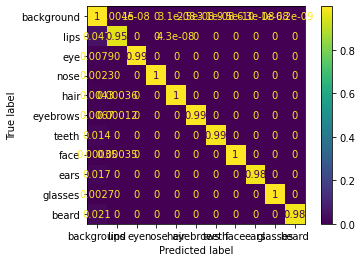

In [69]:
cfm_final = np.zeros((11, 11))

for i in range(11):
    for j in range(11):
        new_val = cfm[i, j] / np.sum(cfm[i])
    
        cfm_final[i, j] = new_val
        
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

NameError: name 'CLASSES' is not defined

In [66]:

# disp.

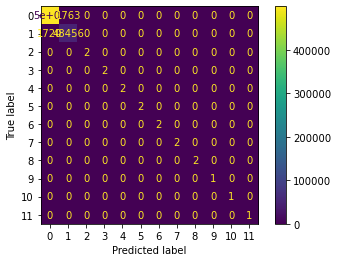

In [67]:
disp.plot()

In [33]:


for i in range(11):
    pred_mask.long().shape

torch.Size([1, 11, 224, 224])

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(mask.long().view(-1, 1).numpy(), pred_mask.long().view(-1, 1).numpy())

array([[499997,   1763],
       [  1720,  48456]])

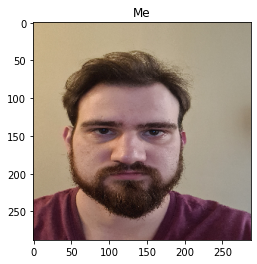

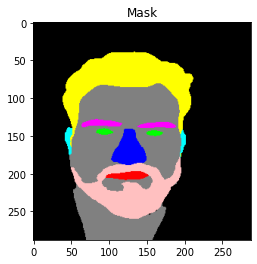

In [4]:
c_v = 288
convert_size = (c_v, c_v)

# read img
image = cv2.imread("../data/me/me1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resize = A.Resize(convert_size[0], convert_size[1], cv2.INTER_LANCZOS4)
image = resize(image=image)["image"]
    
# preprocessing for torch
img = np.expand_dims(image, axis=0)
img = (img.astype(np.float32) / 255).astype(np.float32)
img = torch.FloatTensor(img)
img = torch.permute(img, (0, 3, 1, 2))
pred = model(img)[0]
preds_softmax = torch.argmax(pred.softmax(dim=0), dim=0)

# classes
CLASSES = {"background": [0, 0, 0], "lips": [255, 0, 0], "eye": [0, 255, 0], "nose": [0, 0, 255],
           "hair": [255, 255, 0], "eyebrows": [255, 0, 255], "teeth": [255, 255, 255], "face": [128, 128, 128],
           "ears": [0, 255, 255], "glasses": [0, 128, 128], "beard": [255, 192, 192]}
    
# create mask
mask = np.ones((convert_size[0], convert_size[1], 3))
for i in range(11):
    class_name = list(CLASSES.keys())[i]
    class_color = CLASSES[class_name]
    mask[(preds_softmax == i).numpy()] = class_color

# Viz
plt.imshow(image)
plt.title("Me")
plt.show()
plt.imshow(mask.astype(np.uint8))
plt.title("Mask")
plt.show()

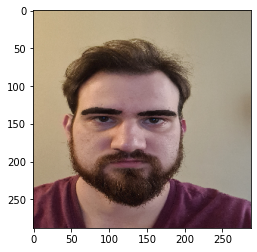

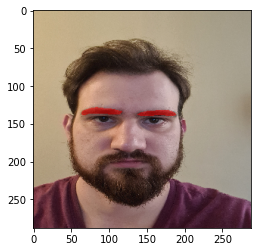

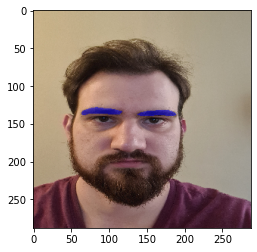

In [5]:
# Eyebrows examples
image_eyebrows = image.copy()
class_mask = (preds_softmax == 5).numpy()
image_eyebrows[class_mask] = ((image_eyebrows[class_mask] + [0, 0, 0]) / 2).astype(np.uint8)
plt.imshow(image_eyebrows)
plt.show()

image_eyebrows = image.copy()
class_mask = (preds_softmax == 5).numpy()
image_eyebrows[class_mask] = ((image_eyebrows[class_mask] + [255, 0, 0]) / 2).astype(np.uint8)
plt.imshow(image_eyebrows)
plt.show()

image_eyebrows = image.copy()
class_mask = (preds_softmax == 5).numpy()
image_eyebrows[class_mask] = ((image_eyebrows[class_mask] + [0, 0, 255]) / 2).astype(np.uint8)
plt.imshow(image_eyebrows)
plt.show()

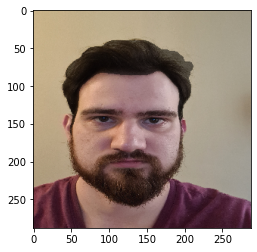

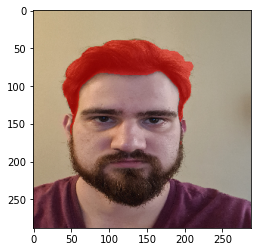

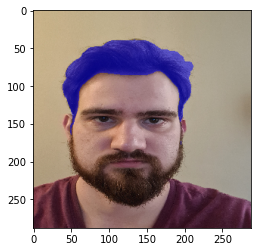

In [6]:
# Hair examples
image_hair = image.copy()
class_mask = (preds_softmax == 4).numpy()
image_hair[class_mask] = ((image_hair[class_mask] + [0, 0, 0]) / 2).astype(np.uint8)
plt.imshow(image_hair)
plt.show()

image_hair = image.copy()
class_mask = (preds_softmax == 4).numpy()
image_hair[class_mask] = ((image_hair[class_mask] + [255, 0, 0]) / 2).astype(np.uint8)
plt.imshow(image_hair)
plt.show()

image_hair = image.copy()
class_mask = (preds_softmax == 4).numpy()
image_hair[class_mask] = ((image_hair[class_mask] + [0, 0, 255]) / 2).astype(np.uint8)
plt.imshow(image_hair)
plt.show()